# Data Preprocessing 

### LIbrary Imports

In [1]:
import mne
import numpy as np
import torch
from torch.utils.data import DataLoader

%matplotlib inline

In [ ]:
from bci_aic3.data import BCIDataset, load_raw_data
from bci_aic3.models.eegnet import EEGNet
from bci_aic3.paths import (
    CONFIG_DIR,
    LABEL_MAPPING_PATH,
    RAW_DATA_DIR,
    TRAINING_STATS_PATH,
)
from bci_aic3.util import (
    load_training_stats,
    apply_normalization,
    read_json_to_dict,
    save_training_stats,
)

### Loading the Training Data

In [4]:
label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)

In [ ]:
train_mi = BCIDataset(
    "train.csv",
    base_path=RAW_DATA_DIR,
    task_type="MI",
    split="train",
    label_mapping=label_mapping,
)

0it [00:00, ?it/s]

2400it [02:13, 17.96it/s]


In [5]:
training_stats = train_mi.get_training_stats()
training_stats

NameError: name 'train_mi' is not defined

In [6]:
train_mi_loader = DataLoader(train_mi, batch_size=len(train_mi), shuffle=False)

NameError: name 'train_mi' is not defined

In [77]:
# 2. Pull everything into numpy
mi_data_batch, mi_labels = next(iter(train_mi_loader))
# shape -> [n_epochs, n_channels, n_times]
mi_data = mi_data_batch.numpy()
mi_labels = mi_labels.numpy()

In [78]:
mi_data.shape, mi_labels.shape

((2400, 8, 2250), (2400,))

In [79]:
mi_data.min(), mi_data.max(), mi_data.mean(), mi_data.std()

(np.float32(160222.05),
 np.float32(710464.4),
 np.float32(308725.7),
 np.float32(65676.734))

In [80]:
# 3. Define channel info
SCALING_FACTOR = 1e-6  # MNE constant to convert
sfreq = 250.0  # your sampling rate
ch_names = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
ch_types = ["eeg"] * mi_data.shape[1]
info = mne.create_info(ch_names, sfreq, ch_types)

# montage = mne.channels.make_standard_montage('standard_1020')
# info.set_montage(montage, on_missing='warn')

In [81]:
mi_notch_freq = 50
mi_lfreq = 6.
mi_hfreq = 32.
mi_baseline = (0, 1)
mi_tmin = 2.
mi_tmax = 8.

In [ ]:
# 4. Apply a notch filter  for power line noise (50 Hz)
# before creating the EpochsArray
filtered_data = mne.filter.notch_filter(mi_data.astype(float) * SCALING_FACTOR,
                                        sfreq, 
                                        mi_notch_freq,
                                        method='fft')

print(filtered_data.shape)

filtered_data = mne.filter.filter_data(filtered_data, 
                                        sfreq=sfreq, 
                                        l_freq=mi_lfreq,
                                        h_freq=mi_hfreq,
                                        verbose=True)
print(filtered_data.shape)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

(2400, 8, 2250)
Setting up band-pass filter from 6 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequen

In [99]:
# 5. Create an MNE EpochsArray
mi_epochs = mne.EpochsArray(
    filtered_data , info, events=None, event_id=None, tmin=0.0
)
mi_epochs.event_id = dict((str(lbl), int(lbl)) for lbl in np.unique(mi_labels))
mi_epochs.events = np.column_stack(
    (np.arange(len(mi_labels)), np.zeros(len(mi_labels), int), mi_labels)
)

Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated


In [100]:
mi_epochs.get_data().min(), mi_epochs.get_data().max(), mi_epochs.get_data().mean(), mi_epochs.get_data().std()

(np.float64(-0.026691241907370836),
 np.float64(0.02661565374292244),
 np.float64(-1.5237833667868106e-07),
 np.float64(0.0002203805010178084))

### Preprocessing

In [4]:
# 1. Apply Band-Pass Filter
# mi_epochs.filter(l_freq=mi_lfreq, h_freq=mi_hfreq,verbose=False)

# 2. Baseline Correction
# Assuming the first second (from t=0 to t=1) is the baseline period
mi_epochs.apply_baseline(baseline=(0, 1))

# 3. Crop epochs to the relevant time window for motor imagery
# For example, from second 2 to second 8 of the trial
mi_epochs.crop(tmin=2., tmax=8.)

# 4. Get the data back into a numpy array for EEGNet
# MNE gives it in (epochs, channels, time), which is what you need
processed_mi_data = mi_epochs.get_data()

NameError: name 'mi_epochs' is not defined

In [3]:
processed_mi_data.min(), processed_mi_data.max(), processed_mi_data.mean(), processed_mi_data.std()

NameError: name 'processed_mi_data' is not defined

In [102]:
mi_epochs.get_data().min(), mi_epochs.get_data().max(), mi_epochs.get_data().mean(), mi_epochs.get_data().std()

(np.float64(-0.02577093188613795),
 np.float64(0.024409435953810104),
 np.float64(8.948232670259047e-07),
 np.float64(0.00017401524298380402))

In [103]:
print("Original MI shape:", mi_data.shape)
print("Processed MI shape:", processed_mi_data.shape)
# Expected processed shape might be (n_epochs, 8, 1500) if cropped from t=2 to t=8

Original MI shape: (2400, 8, 2250)
Processed MI shape: (2400, 8, 1501)


In [104]:
# 3. Define channel info
SCALING_FACTOR = 1e-6  # MNE constant to convert
sfreq = 250.0  # your sampling rate
ch_names = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
ch_types = ["eeg"] * mi_data.shape[1]
info = mne.create_info(ch_names, sfreq, ch_types)

# montage = mne.channels.make_standard_montage('standard_1020')
# info.set_montage(montage, on_missing='warn')

In [105]:
raw_epochs = mne.EpochsArray(
    mi_data * SCALING_FACTOR, info, events=None, event_id=None, tmin=0.0
)

Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated


In [106]:
processed_epochs = mne.EpochsArray(
    processed_mi_data, info, events=None, event_id=None, tmin=1.0
)

Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated


In [107]:
processed_mi_data.mean()

np.float64(8.948232670259047e-07)

In [108]:
(mi_data * SCALING_FACTOR).mean()

np.float32(0.30872568)

In [109]:
import matplotlib.pyplot as plt
n_channels = 8

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated


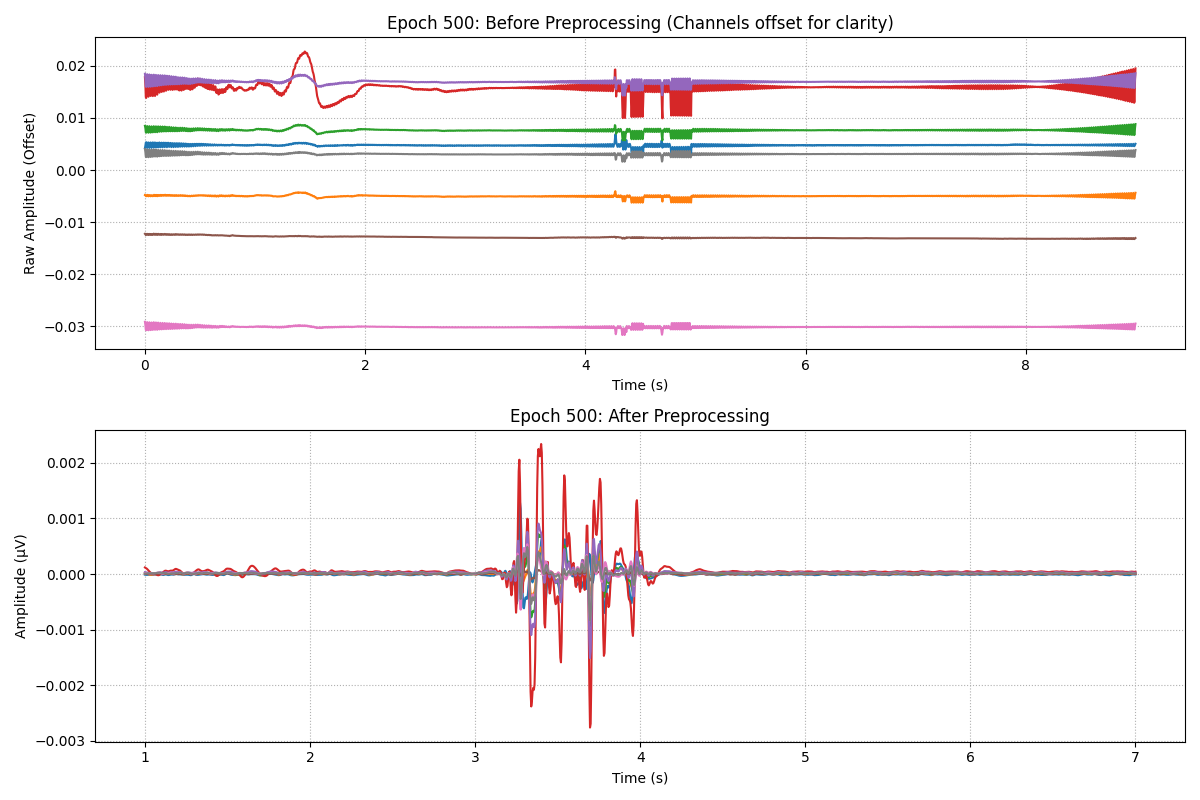

In [117]:
notched_data = mne.filter.notch_filter(mi_data.astype(float) * SCALING_FACTOR,
                                        sfreq, 
                                        mi_notch_freq,
                                        method='fft')

raw_epochs = mne.EpochsArray(
    notched_data, info, events=None, event_id=None, tmin=0.0
)

In [ ]:

# Choose a random epoch to inspect
epoch_index_to_plot = 500

# Get the data for the single epoch
raw_data_single_epoch = raw_epochs[epoch_index_to_plot].get_data(copy=True).squeeze()
# Note: get_data() returns (n_epochs, n_channels, n_times). We squeeze to remove the first dimension.

# The processed epoch has a different time axis due to cropping
processed_data_single_epoch = processed_epochs[epoch_index_to_plot].get_data(copy=True).squeeze()
times_processed = processed_epochs.times

# MNE's default scaler can handle the large raw ADC values for plotting
# But for manual plotting with matplotlib, it's easier to scale them down
raw_data_single_epoch_scaled = raw_data_single_epoch - np.mean(raw_data_single_epoch)

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Plot "Before"
for i in range(n_channels):
    axes[0].plot(raw_epochs.times, raw_data_single_epoch_scaled[i], label=ch_names[i])
axes[0].set_title(f'Epoch {epoch_index_to_plot}: Before Preprocessing (Channels offset for clarity)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Raw Amplitude (Offset)')
axes[0].grid(True, linestyle=':')

# Plot "After"
for i in range(n_channels):
    # We multiply by 1e6 to scale the data from Volts (what MNE uses internally) to microVolts for plotting
    axes[1].plot(times_processed, processed_data_single_epoch[i], label=ch_names[i])
axes[1].set_title(f'Epoch {epoch_index_to_plot}: After Preprocessing')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].grid(True, linestyle=':')

fig.tight_layout()
plt.show()